# Importing The libraries

In [1]:
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import hvplot.pandas 

# Data loading

We'll just be loading the unit 5 training and synthetic dataset

In [2]:
dataset_root = Path(r"./dataset") # Raw string works without escaping \


@dataclass
class Case():
    info: pd.DataFrame
    measurements: pd.DataFrame


class RawDataset():

    def __init__(self, root, unit = "VG4", load_training=False, load_synthetic=False) -> None:
        
        
        read_pq_file = lambda f: pq.read_table(root / f).to_pandas()
        
        
        cases = {
            "test": [f"{unit}_generator_data_testing_real_measurements.parquet", root / f"{unit}_generator_data_testing_real_info.csv" ], 
        }
        
        if load_training:
            cases = {
                **cases,
                "train": [f"{unit}_generator_data_training_measurements.parquet", root / f"{unit}_generator_data_training_info.csv" ], 
            }
        
        if load_synthetic:
            cases = {
                **cases,
                "test_s01": [f"{unit}_generator_data_testing_synthetic_01_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_01_info.csv"], 
                "test_s02": [f"{unit}_generator_data_testing_synthetic_02_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_02_info.csv"]
            }
        
        
        self.data_dict = dict()
        
        for id_c, c in cases.items():
            # if you need to verify the parquet header:
            # pq_rows = RawDataset.read_parquet_schema_df(root / c[0])
            info = pd.read_csv(c[1])
            measurements = read_pq_file(c[0])
            self.data_dict[id_c] = Case(info, measurements)
            
        
        
    @staticmethod
    def read_parquet_schema_df(uri: str) -> pd.DataFrame:
        """Return a Pandas dataframe corresponding to the schema of a local URI of a parquet file.

        The returned dataframe has the columns: column, pa_dtype
        """
        # Ref: https://stackoverflow.com/a/64288036/
        schema = pq.read_schema(uri, memory_map=True)
        schema = pd.DataFrame(({"column": name, "pa_dtype": str(pa_dtype)} for name, pa_dtype in zip(schema.names, schema.types)))
        schema = schema.reindex(columns=["column", "pa_dtype"], fill_value=pd.NA)  # Ensures columns in case the parquet file has an empty dataframe.
        return schema




rds_u5 = RawDataset(dataset_root, "VG5", load_synthetic=True, load_training=True)

# Splitting the dataframes

The dataframes are split between the time series measured by the sensors ($Y_t$), the control time series ($X_t$) and the operating modes (OP).

In [67]:
Operating_modes_name = ["turbine_mode",
                        "equilibrium_turbine_mode",
                        "pump_mode",
                        "equilibrium_pump_mode",
                        "short_circuit_mode",
                        "equilibrium_short_circuit_mode",
                        "machine_on",
                        "machine_off",
                        "dyn_only_on",
                        "all"]

def extracting_name_groups_time_series(rds, set_type="train"):
    """This function fetches the name of the control and sensors time series

    Args:
        rds (class RawDataSet): _description_
        set_type (str, optional): _description_. Defaults to "train".

    Returns:
        2 lists: they hold the names of the two groups
    """
    df_name_control_sensors = rds.data_dict[set_type].info
    
    control_time_series_name = df_name_control_sensors[(df_name_control_sensors['control_signal']==True) 
                                            & (df_name_control_sensors["signal_type"]=="Measurement")]
    
    sensors_time_series_name = df_name_control_sensors[(df_name_control_sensors['control_signal']==False) 
                                            & (df_name_control_sensors["signal_type"]=="Measurement")]
    return control_time_series_name["attribute_name"], sensors_time_series_name["attribute_name"]


def extracting_groups_time_series(rds, set_type="train"):
    """The function extracts the control, sensors and operating modes time series out of the main one.
    It can be specified on which type of dataset it is done (train, test, synthetic).

    Args:
        rds (class RawDataSet): _description_
        set_type (str, optional): Choose the type of dataset. Defaults to "train".

    Returns:
        _type_: _description_
    """
    control_time_series_name, sensors_time_series_name = extracting_name_groups_time_series(rds, set_type=set_type)
    
    control_df = rds.data_dict[set_type].measurements[control_time_series_name]
    
    sensors_df = rds.data_dict[set_type].measurements[sensors_time_series_name]
    
    operating_modes_df = rds.data_dict[set_type].measurements[Operating_modes_name]
    
    return control_df, sensors_df, operating_modes_df

def get_indexes_operating_mode(operating_modes_df, operating_conditions):
    """
    Get the indexes of the rows in the DataFrame that satisfy all the conditions in the dictionary.

    Parameters:
    operating_modes_df (pd.DataFrame): The DataFrame to search.
    operating_conditions (dict): A dictionary where keys are column names and values are the values to match in those columns.

    Returns:
    pd.Index: The indexes of the rows that match all conditions.
    """
    # Start with a boolean Series that is True for all rows
    mask = pd.Series([True] * len(operating_modes_df), index=operating_modes_df.index)

    # Apply each condition to the mask
    for column, value in operating_conditions.items():
        mask &= (operating_modes_df[column] == value)

    # Return the indexes where the mask is True
    return operating_modes_df[mask].index

In [6]:
control_df, sensors_df, operating_modes_df = extracting_groups_time_series(rds_u5)

## Extracting the data for turbine mode in steady-state

In [77]:
operating_conditions_turbine_steady_state = {"dyn_only_on" : False,
                                            "turbine_mode" : True,
                                            "equilibrium_turbine_mode" : True}

index_turbine_steady_state = get_indexes_operating_mode(operating_modes_df,
                                                        operating_conditions_turbine_steady_state)

In [ ]:
control_df.loc[index_turbine_steady_state][::50].plot(figsize=(12,10))

<Axes: >

# Tests

In [8]:
control_time_series_name, sensors_time_series_name = extracting_name_groups_time_series(rds_u5)

df = rds_u5.data_dict["train"].measurements

df_steady_state = df[(df["dyn_only_on"] == False) & 
                    (df["pump_mode"] == True) &
                    (df["equilibrium_pump_mode"] == True)]

In [23]:
control_steady_state = df_steady_state[control_time_series_name]

sensors_steady_state = df_steady_state[sensors_time_series_name]

<Axes: >

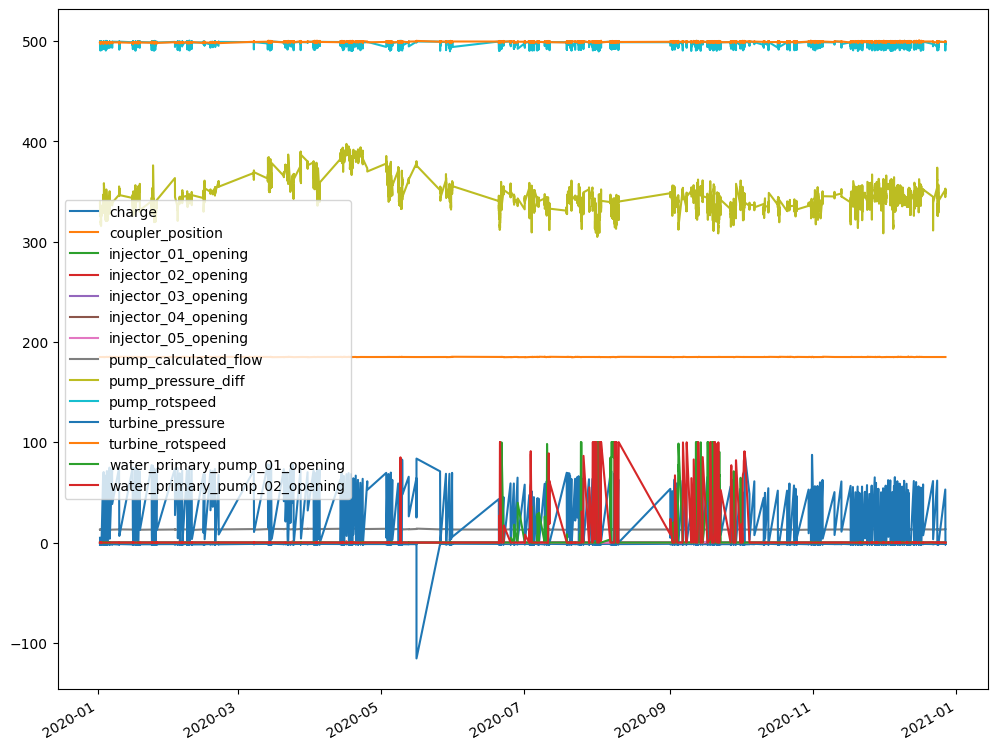

In [21]:
control_steady_state[::10].plot(figsize=(12,10))

<Axes: >

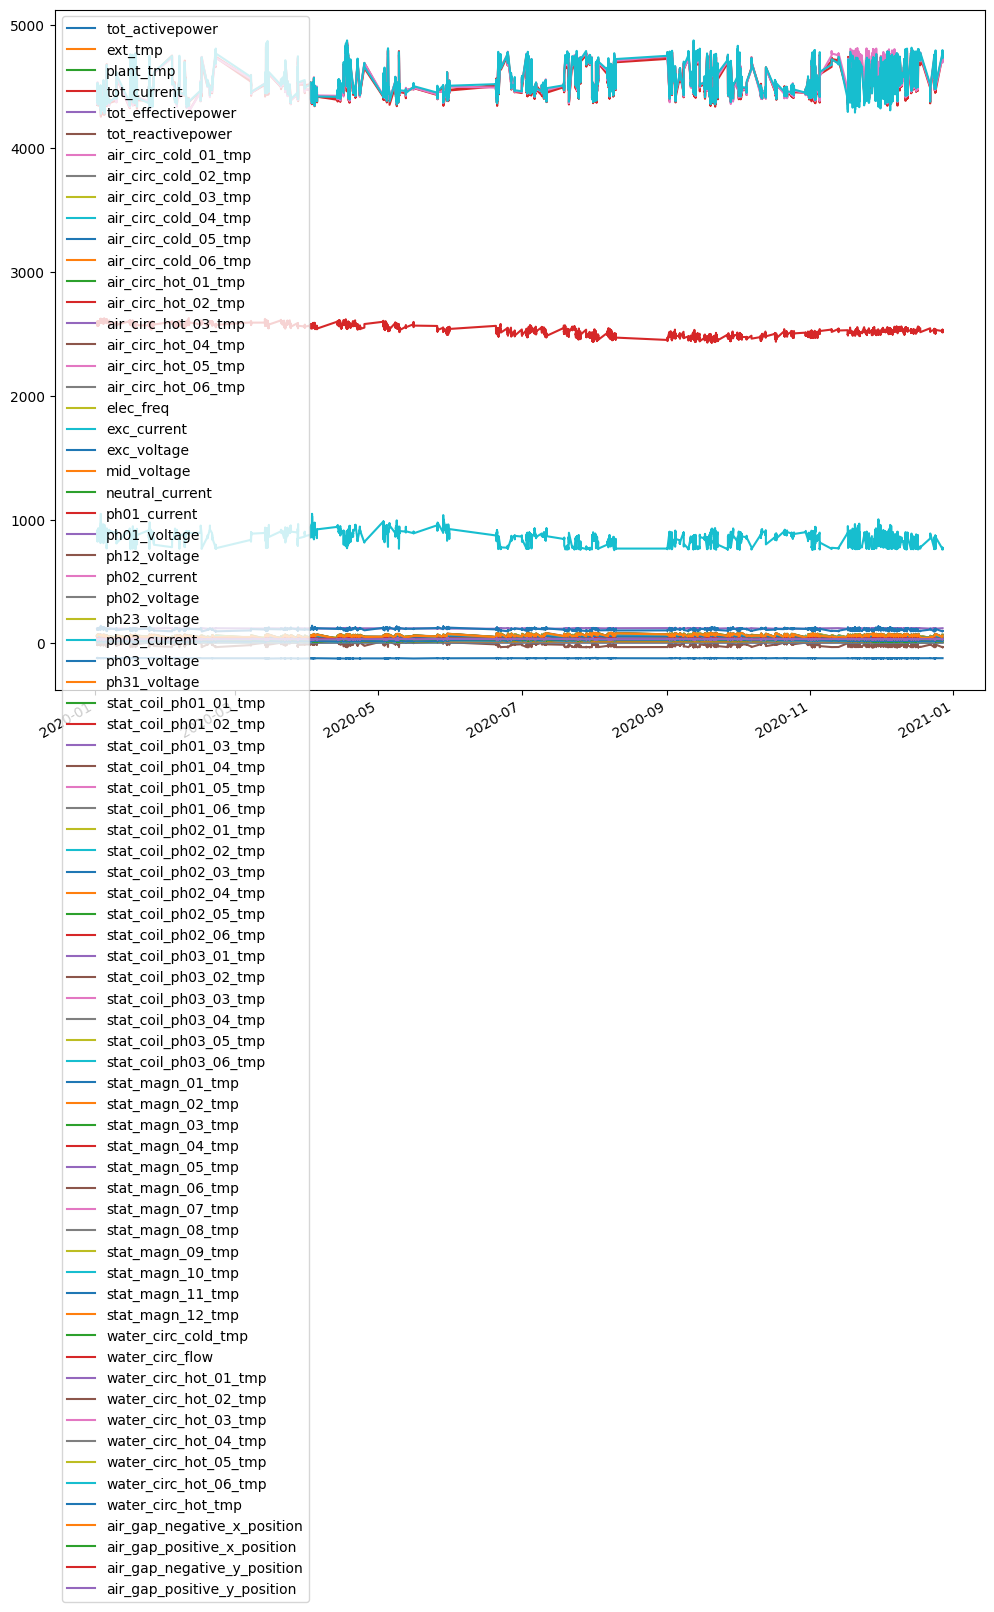

In [24]:
sensors_steady_state[::10].plot(figsize=(12,10))